# LABORATORIUM 3 - REGRESJA LOGISTYCZNA

### 3.1 Porównanie sklearn i własnej implementacji klasyfikatora na syntetycznych zbiorach

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.datasets import make_regression
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


#### Funkcje generujące zbiory:

In [2]:
def generate_data(n_samples, n_features, random_state):
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_features,
        n_redundant=0,
        n_clusters_per_class=1,
        random_state=random_state
    )
    # y = 2 * y - 1
    return X, y

def generate_moons(n_samples, random_state):
    X_moons, y_moons = make_moons(n_samples=n_samples, noise=0.1, random_state=random_state)
    # y_moons = 2 * y_moons - 1
    
    return X_moons, y_moons

#### Funkcje do liczenia metryk i statystyk:

In [3]:
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd

def compute_metrics(y_test, y_pred, classifier_name, dataset_name, labels=[0,1]):
    # macierz pomyłek
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # czułość i swoistość
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    #skuteczność
    accuracy = accuracy_score(y_test, y_pred)
    
    # krzywa roc i auc
    fpr, tpr, thresholds  = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    print(f"{classifier_name} na {dataset_name}:")
    print(f"Skuteczność: {accuracy*100:.4f}%")
    print(f"Czułość (Recall): {sensitivity*100:.4f}%")
    print(f"Swoistość: {specificity*100:.4f}%")
    print(f"ROC AUC: {roc_auc:.4f}")

    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    display.plot(cmap="Greens")
    plt.title("Macierz pomyłek")
    plt.show

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.xlabel('Współczynnik FP (1 - Specificity)')
    plt.ylabel('współczynnik TP (Sensitivity)')
    plt.title('Krzywa ROC')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

def plot_decision_boundary(X, y, w, title, prediction_fun=None):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    X_grid = np.c_[xx.ravel(), yy.ravel(), np.ones((xx.ravel().shape[0], 1))]
    Z = prediction_fun(X_grid @ w)
    Z = (Z >= 0.5).astype(int)
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.title(title)
    plt.show()

#### Funkcja *sigmoid* do **gradient descent**:

In [4]:
def sigmoid(s, beta=1):
    return 1 / (1 + np.exp(-beta * s))

#### Implementacja właśnej funkcji regresji logistycznej: 

In [5]:
def logistic_regression(X, y, X_test=None, iterations=500, eta=0.001, epsilon=1e-8):
    y = np.array(y)
    n_samples, n_features = X.shape
    
    X_bias = np.hstack((X, np.ones((X.shape[0], 1))))
    w = np.random.randn(n_features + 1) * 0.01
    prev_w = w.copy()
    iters = 0
    for _ in range(iterations):
        iters += 1
        for j in range(len(X_bias)):
            x = X_bias[j]
            t = y[j]

            s = x.T @ w
            pred = sigmoid(s,5)
            
            grad = eta * (t - pred) * pred * (1 - pred) * x
            w += grad

        if np.all(np.abs(w - prev_w) < epsilon):
            break
        prev_w = w.copy()

    if X_test is None:
        X_test = X_bias
    else:
        X_test = np.hstack((X_test, np.ones((X_test.shape[0], 1))))
    
    predictions = []
    for j in range(len(X_test)):
        s = np.dot(X_test[j].T, w)
        predictions.append(1 if sigmoid(s) >= 0.5 else 0)

    return predictions, w, iters

#### Implementacja funkcji regresji logistycznej z *sklearn*:

In [6]:
def logistic_sklearn(X, y, iterations=500, eta=0.001):
    lgr = LogisticRegression(max_iter=iterations)
    lgr.fit(X, y)

    predictions = lgr.predict(X)
    return predictions

#### **Obliczenia**:

Własna implementacja:
Czas wykonania: 14.05865s. Wykonano: 11 iteracji.
Własna na GenerateData:
Skuteczność: 93.9884%
Czułość (Recall): 92.5869%
Swoistość: 95.3846%
ROC AUC: 0.9399


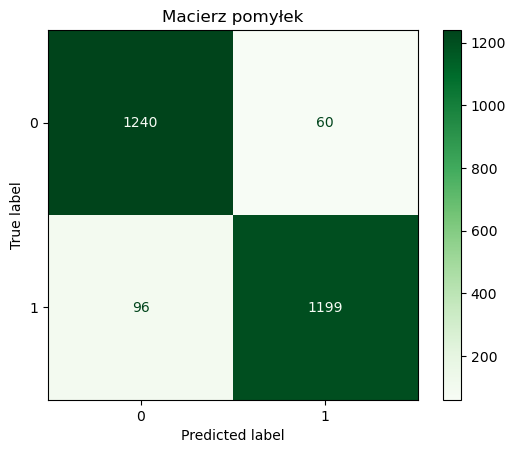

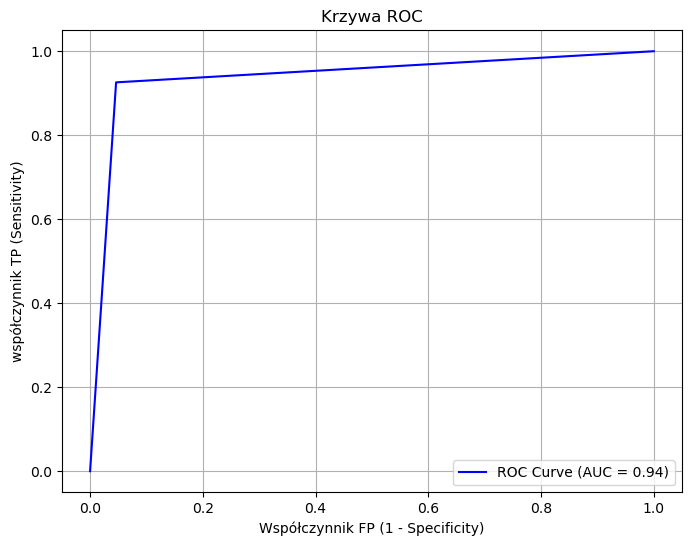

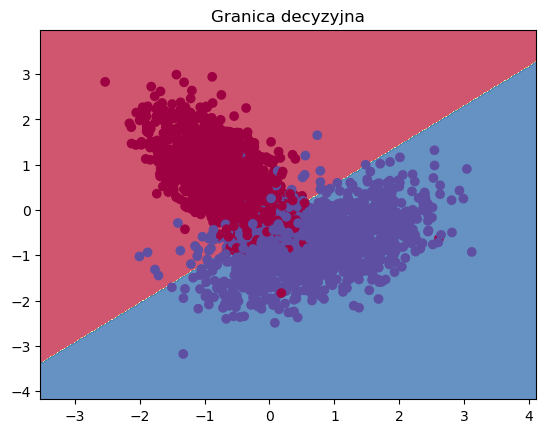

Sklearn:
Czas wykonania: 0.21771s.
Sklearn na GenerateData:
Skuteczność: 94.4894%
Czułość (Recall): 95.1351%
Swoistość: 93.8462%
ROC AUC: 0.9449


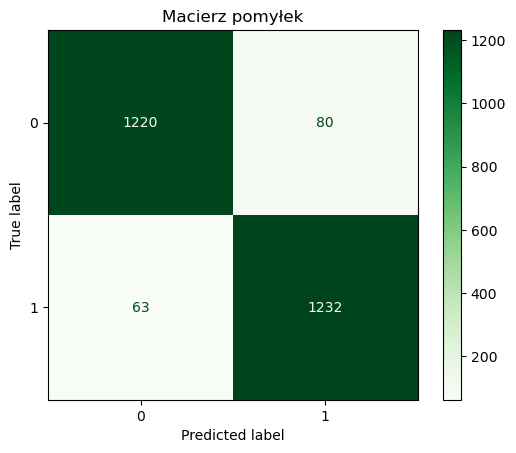

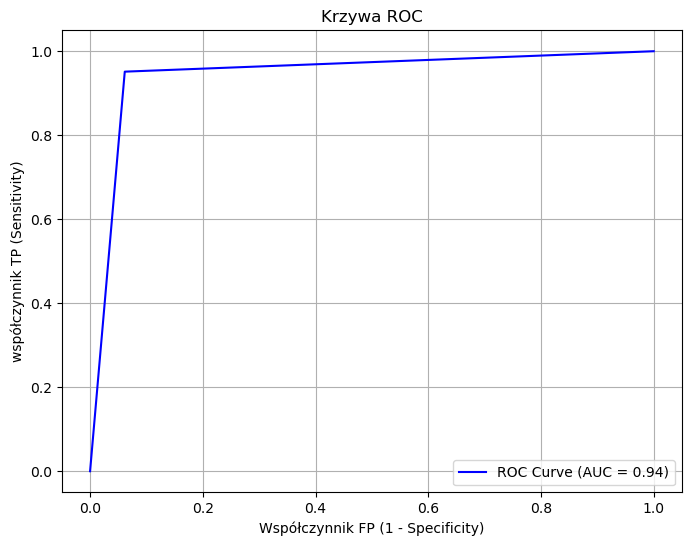

In [7]:
X, y = generate_data(2595, 2, 259195)
X = (X - X.mean(axis=0)) / X.std(axis=0)
max_iters = 1000
eta = 1

print("Własna implementacja:")
start = time.time()
for _ in range(100):
    predictions1, w, iterations = logistic_regression(X, y, iterations=max_iters, eta=eta)
end = time.time()
print(f"Czas wykonania: {end - start:.5f}s. Wykonano: {iterations} iteracji.")
compute_metrics(y, predictions1, "Własna", "GenerateData")
plot_decision_boundary(X, y, w, "Granica decyzyjna", sigmoid)

print("Sklearn:")
start = time.time()
for _ in range(100):
    predictions2 = logistic_sklearn(X, y, max_iters, eta)
end = time.time()
print(f"Czas wykonania: {end - start:.5f}s.")
compute_metrics(y, predictions2, "Sklearn", "GenerateData")

Własna implementacja:
Czas wykonania: 4.26333s. Wykonano: 3 iteracji.
Własna na MakeMoons:
Skuteczność: 87.2832%
Czułość (Recall): 83.2820%
Swoistość: 91.2876%
ROC AUC: 0.8728


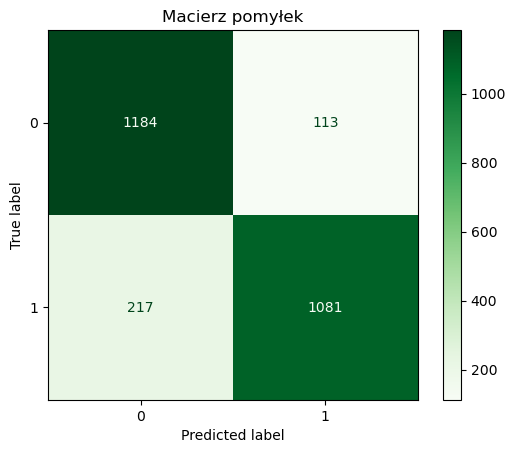

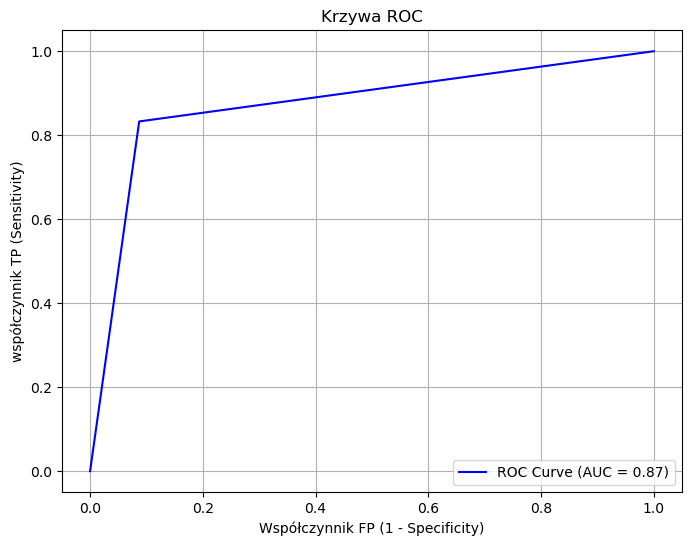

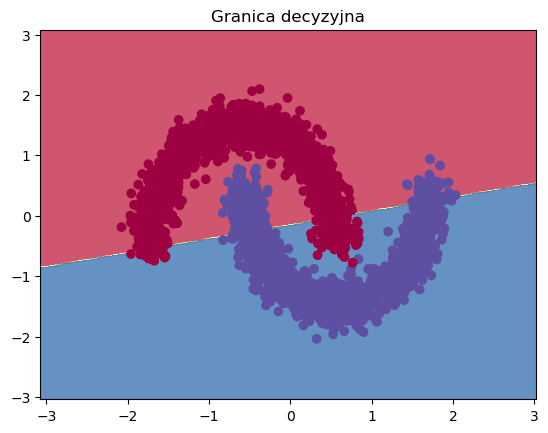

Sklearn:
Czas wykonania: 0.20226s.
Sklearn na MakeMoons:
Skuteczność: 87.8613%
Czułość (Recall): 87.9815%
Swoistość: 87.7409%
ROC AUC: 0.8786


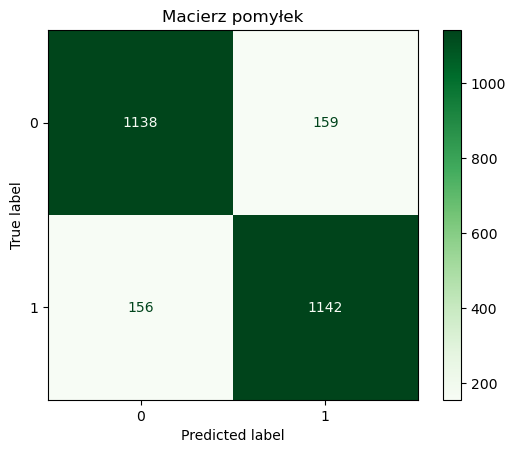

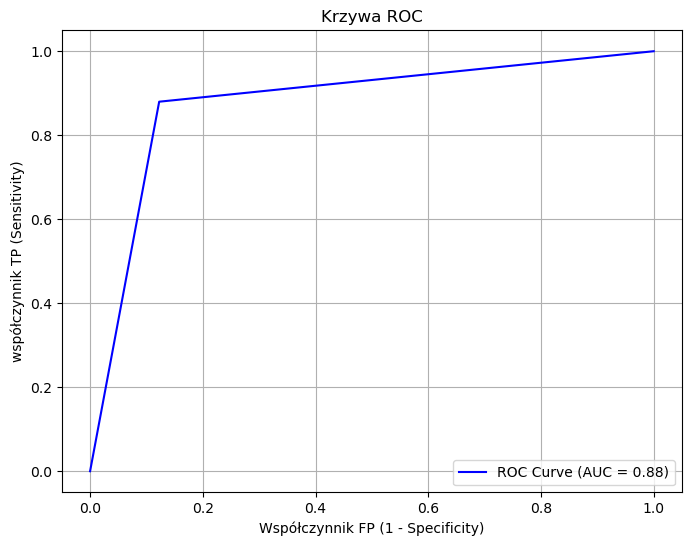

In [8]:
X_moons, y_moons = generate_moons(2595, 259195)
X_moons = (X_moons - X_moons.mean(axis=0)) / X_moons.std(axis=0)

print("Własna implementacja:")
start = time.time()
for _ in range(100):
    predictions1, w, iterations = logistic_regression(X_moons, y_moons, iterations=max_iters, eta=eta)
end = time.time()
print(f"Czas wykonania: {end - start:.5f}s. Wykonano: {iterations} iteracji.")
compute_metrics(y_moons, predictions1, "Własna", "MakeMoons")
plot_decision_boundary(X_moons, y_moons, w, "Granica decyzyjna", sigmoid)

print("Sklearn:")
start = time.time()
for _ in range(100):
    predictions2 = logistic_sklearn(X_moons, y_moons, max_iters, eta)
end = time.time()
print(f"Czas wykonania: {end - start:.5f}s.")
compute_metrics(y_moons, predictions2, "Sklearn", "MakeMoons")

### Obserwacje i wnioski:

* Funkcja od sklearn działa znacznie szybciej
* Dla obu zbiorów danych nie trzeba wykonywać 1000 iteracji, czasami wystarczy parenaście, by znaleźć optymalny wynik i osiągnąć dobry wynik klasyfikacji.

### 3.2 Poprawny preprocessing danych, nauczenie modeli dla regionów i porównanie ich skuteczności

#### Pobranie i zaczytanie danych z pliku:

In [9]:
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import StandardScaler

In [10]:
data = pd.read_csv("rainAUS.csv")
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


#### Usunięcie kolumn z brakami powyżej *30%* i kolumny *Risk_MM*, separacja *target*:

In [11]:
data = data.loc[:, data.isnull().mean() < 0.3]

if 'Risk_MM' in data.columns:
    print("Usuwam kolumnę Risk_MM")
    data = data.drop(columns=['Risk_MM'])

target = data['RainTomorrow']
data = data.drop(columns=['RainTomorrow'])

print(target.head())
data

0    No
1    No
2    No
3    No
4    No
Name: RainTomorrow, dtype: object


,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday
0,2008-12-01,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No
1,2008-12-02,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No
2,2008-12-03,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No
3,2008-12-04,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No
4,2008-12-05,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,15.1,26.0,No


#### Imputacja danych - przygotowanie:
* Dzielimy cechy na *kategoryczne* i *numeryczne*
* W kategorycznych sprawdzamy, które faktycznie cechy zawierają NA

In [12]:
cat_cols = data.select_dtypes(include='object').columns
num_cols = data.select_dtypes(include=np.number).columns

print("Cechy kategoryczne: ")
print(cat_cols.to_numpy().astype(str))
print("\nCechy numeryczne: ")
print(num_cols.to_numpy().astype(str))

print("\nIlość NaN w poszczególnych cechach:")
for cat in cat_cols:    
    print(f"{cat}: {(data[cat].isna()).sum()}")

for num in num_cols:
    print(f"{num}: {(data[num].isna()).sum()}")

Cechy kategoryczne: 
['Date' 'Location' 'WindGustDir' 'WindDir9am' 'WindDir3pm' 'RainToday']

Cechy numeryczne: 
['MinTemp' 'MaxTemp' 'Rainfall' 'WindGustSpeed' 'WindSpeed9am'
 'WindSpeed3pm' 'Humidity9am' 'Humidity3pm' 'Pressure9am' 'Pressure3pm'
 'Temp9am' 'Temp3pm']

Ilość NaN w poszczególnych cechach:
Date: 0
Location: 0
WindGustDir: 10326
WindDir9am: 10566
WindDir3pm: 4228
RainToday: 3261
MinTemp: 1485
MaxTemp: 1261
Rainfall: 3261
WindGustSpeed: 10263
WindSpeed9am: 1767
WindSpeed3pm: 3062
Humidity9am: 2654
Humidity3pm: 4507
Pressure9am: 15065
Pressure3pm: 15028
Temp9am: 1767
Temp3pm: 3609


#### Przeprowadzamy imputacje danych:

In [13]:
imputer_cat = SimpleImputer(strategy='most_frequent')
imputer_num = SimpleImputer(strategy='median')

data[cat_cols] = imputer_cat.fit_transform(data[cat_cols])
data[num_cols] = imputer_num.fit_transform(data[num_cols])

print("\nIlość NaN w poszczególnych cechach po imputacji:")
for cat in cat_cols:    
    print(f"{cat}: {(data[cat].isna()).sum()}")

for num in num_cols:
    print(f"{num}: {(data[num].isna()).sum()}")

# data.tail()
data.columns


Ilość NaN w poszczególnych cechach po imputacji:
Date: 0
Location: 0
WindGustDir: 0
WindDir9am: 0
WindDir3pm: 0
RainToday: 0
MinTemp: 0
MaxTemp: 0
Rainfall: 0
WindGustSpeed: 0
WindSpeed9am: 0
WindSpeed3pm: 0
Humidity9am: 0
Humidity3pm: 0
Pressure9am: 0
Pressure3pm: 0
Temp9am: 0
Temp3pm: 0


Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday'],
      dtype='object')

#### Winsoryzacja danych odstających ponad **1.5 IQR**: 

In [14]:
def winsorize_column(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1

    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    print(f"Lower: {lower}, Upper: {upper}")
    return column.clip(lower=lower, upper=upper)

for col in num_cols:
    print(f"\n{col} przed => Min: {data[col].min()}, Max: {data[col].max()}")
    data[col] = winsorize_column(data[col])
    print(f"{col} po => Min: {data[col].min()}, Max: {data[col].max()}")


MinTemp przed => Min: -8.5, Max: 33.9
Lower: -5.950000000000002, Upper: 30.450000000000003
MinTemp po => Min: -5.950000000000002, Max: 30.450000000000003

MaxTemp przed => Min: -4.8, Max: 48.1
Lower: 2.700000000000001, Upper: 43.5
MaxTemp po => Min: 2.700000000000001, Max: 43.5

Rainfall przed => Min: 0.0, Max: 371.0
Lower: -0.8999999999999999, Upper: 1.5
Rainfall po => Min: 0.0, Max: 1.5

WindGustSpeed przed => Min: 6.0, Max: 135.0
Lower: 8.5, Upper: 68.5
WindGustSpeed po => Min: 8.5, Max: 68.5

WindSpeed9am przed => Min: 0.0, Max: 130.0
Lower: -11.0, Upper: 37.0
WindSpeed9am po => Min: 0.0, Max: 37.0

WindSpeed3pm przed => Min: 0.0, Max: 87.0
Lower: -3.5, Upper: 40.5
WindSpeed3pm po => Min: 0.0, Max: 40.5

Humidity9am przed => Min: 0.0, Max: 100.0
Lower: 18.0, Upper: 122.0
Humidity9am po => Min: 18.0, Max: 100.0

Humidity3pm przed => Min: 0.0, Max: 100.0
Lower: -5.0, Upper: 107.0
Humidity3pm po => Min: 0.0, Max: 100.0

Pressure9am przed => Min: 980.5, Max: 1041.0
Lower: 1001.0500000

#### Rozwiązanie problemu z datą:

In [15]:
dayofyear = pd.to_datetime(data['Date']).dt.dayofyear
data['DayOfYear_sin'] = np.sin(2 * np.pi * dayofyear / 365)
data['DayOfYear_cos'] = np.cos(2 * np.pi * dayofyear / 365)
data = data.drop(columns=['Date'])
print(data.tail())


       Location  MinTemp  MaxTemp  Rainfall WindGustDir  WindGustSpeed  \
145455    Uluru      2.8     23.4       0.0           E           31.0   
145456    Uluru      3.6     25.3       0.0         NNW           22.0   
145457    Uluru      5.4     26.9       0.0           N           37.0   
145458    Uluru      7.8     27.0       0.0          SE           28.0   
145459    Uluru     14.9     22.6       0.0           W           39.0   

       WindDir9am WindDir3pm  WindSpeed9am  WindSpeed3pm  Humidity9am  \
145455         SE        ENE          13.0          11.0         51.0   
145456         SE          N          13.0           9.0         56.0   
145457         SE        WNW           9.0           9.0         53.0   
145458        SSE          N          13.0           7.0         51.0   
145459        ESE        ESE          17.0          17.0         62.0   

        Humidity3pm  Pressure9am  Pressure3pm  Temp9am  Temp3pm RainToday  \
145455         24.0       1024.6       

#### *One-hot* zmiennych kategorycznych:

In [16]:
cat_cols = cat_cols.drop(['Location', 'Date'])
data_cat = data[cat_cols]
df_cat = pd.get_dummies(data_cat, columns=cat_cols, drop_first=True)
print(df_cat.shape)
print(df_cat.columns)

(145460, 46)
Index(['WindGustDir_ENE', 'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE',
       'WindGustDir_NNE', 'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S',
       'WindGustDir_SE', 'WindGustDir_SSE', 'WindGustDir_SSW',
       'WindGustDir_SW', 'WindGustDir_W', 'WindGustDir_WNW', 'WindGustDir_WSW',
       'WindDir9am_ENE', 'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE',
       'WindDir9am_NNE', 'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S',
       'WindDir9am_SE', 'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW',
       'WindDir9am_W', 'WindDir9am_WNW', 'WindDir9am_WSW', 'WindDir3pm_ENE',
       'WindDir3pm_ESE', 'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NNE',
       'WindDir3pm_NNW', 'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE',
       'WindDir3pm_SSE', 'WindDir3pm_SSW', 'WindDir3pm_SW', 'WindDir3pm_W',
       'WindDir3pm_WNW', 'WindDir3pm_WSW', 'RainToday_Yes'],
      dtype='object')


#### Normalizacja danych numerycznych:

In [17]:
scaler = StandardScaler()
df_num = pd.DataFrame(scaler.fit_transform(data[num_cols]), columns=num_cols)
print(df_num.shape)
df_num

(145460, 12)


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
0,0.189751,-0.045242,0.358714,0.357816,0.708308,0.641629,0.109440,-1.443652,-1.518122,-1.251138,-0.013695,0.018905
1,-0.752982,0.266030,-0.627098,0.357816,-1.161737,0.404729,-1.334095,-1.297105,-1.076618,-1.143922,0.032883,0.385833
2,0.111190,0.350922,-0.627098,0.522075,0.591430,0.878529,-1.654880,-1.052860,-1.533347,-1.006073,0.622866,0.224385
3,-0.470162,0.676343,-0.627098,-1.284777,-0.343592,-1.135122,-1.280631,-1.736746,-0.010917,-0.378095,0.172616,0.708730
4,0.833951,1.284738,1.015921,0.111427,-0.811103,0.167829,0.697547,-0.906314,-1.046169,-1.419620,0.126038,1.178398
...,...,...,...,...,...,...,...,...,...,...,...,...
145455,-1.475744,0.025502,-0.627098,-0.709870,-0.109837,-0.898222,-0.959845,-1.345954,1.054784,0.770646,-1.069454,0.106968
145456,-1.350046,0.294328,-0.627098,-1.449037,-0.109837,-1.135122,-0.692524,-1.492501,0.887317,0.586848,-0.945247,0.415188
145457,-1.067226,0.520707,-0.627098,-0.217092,-0.577348,-1.135122,-0.852917,-1.345954,0.506709,0.234567,-0.696833,0.650022
145458,-0.690133,0.534856,-0.627098,-0.956259,-0.109837,-1.372022,-0.959845,-1.345954,0.263121,0.188618,-0.293161,0.635345


### **Finalny zbiór danych:**

In [ ]:
print(df_num.columns, df_num.shape)
print(df_cat.columns, df_cat.shape)
df_final = pd.concat([data['Location'], df_num, df_cat], axis=1)
df_final['RainTomorrow'] = target.map({'No': 0, 'Yes': 1})
df_final = df_final.dropna(subset=['RainTomorrow'])
print(df_final.shape)
df_final

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm'],
      dtype='object') (145460, 12)
Index(['WindGustDir_ENE', 'WindGustDir_ESE', 'WindGustDir_N', 'WindGustDir_NE',
       'WindGustDir_NNE', 'WindGustDir_NNW', 'WindGustDir_NW', 'WindGustDir_S',
       'WindGustDir_SE', 'WindGustDir_SSE', 'WindGustDir_SSW',
       'WindGustDir_SW', 'WindGustDir_W', 'WindGustDir_WNW', 'WindGustDir_WSW',
       'WindDir9am_ENE', 'WindDir9am_ESE', 'WindDir9am_N', 'WindDir9am_NE',
       'WindDir9am_NNE', 'WindDir9am_NNW', 'WindDir9am_NW', 'WindDir9am_S',
       'WindDir9am_SE', 'WindDir9am_SSE', 'WindDir9am_SSW', 'WindDir9am_SW',
       'WindDir9am_W', 'WindDir9am_WNW', 'WindDir9am_WSW', 'WindDir3pm_ENE',
       'WindDir3pm_ESE', 'WindDir3pm_N', 'WindDir3pm_NE', 'WindDir3pm_NNE',
       'WindDir3pm_NNW', 'WindDir3pm_NW', 'WindDir3pm_S', 'WindDir3pm_SE',
       'WindDir3pm

,Location,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,...,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes,RainTomorrow
0,Albury,0.189751,-0.045242,0.358714,0.357816,0.708308,0.641629,0.109440,-1.443652,-1.518122,...,False,False,False,False,False,False,True,False,False,0.0
1,Albury,-0.752982,0.266030,-0.627098,0.357816,-1.161737,0.404729,-1.334095,-1.297105,-1.076618,...,False,False,False,False,False,False,False,True,False,0.0
2,Albury,0.111190,0.350922,-0.627098,0.522075,0.591430,0.878529,-1.654880,-1.052860,-1.533347,...,False,False,False,False,False,False,False,True,False,0.0
3,Albury,-0.470162,0.676343,-0.627098,-1.284777,-0.343592,-1.135122,-1.280631,-1.736746,-0.010917,...,False,False,False,False,False,False,False,False,False,0.0
4,Albury,0.833951,1.284738,1.015921,0.111427,-0.811103,0.167829,0.697547,-0.906314,-1.046169,...,False,False,False,False,False,False,False,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,Uluru,-1.365758,-0.200878,-0.627098,-0.709870,0.123919,-0.661322,-0.532131,-1.199407,1.070009,...,False,False,False,False,False,False,False,False,False,0.0
145455,Uluru,-1.475744,0.025502,-0.627098,-0.709870,-0.109837,-0.898222,-0.959845,-1.345954,1.054784,...,False,False,False,False,False,False,False,False,False,0.0
145456,Uluru,-1.350046,0.294328,-0.627098,-1.449037,-0.109837,-1.135122,-0.692524,-1.492501,0.887317,...,False,False,False,False,False,False,False,False,False,0.0
145457,Uluru,-1.067226,0.520707,-0.627098,-0.217092,-0.577348,-1.135122,-0.852917,-1.345954,0.506709,...,False,False,False,False,False,False,True,False,False,0.0


### Stratyfikacja danych oraz badanie modeli dla każdego z regionów:

#### Funkcja pomocnicza do liczenia metryk dla modeli regionów:

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

def calculate_metrics(y_true, y_pred, region="Region"):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0 
    roc_auc = (recall + specificity) / 2 

    print(f"{region}: Skuteczność: {accuracy:.4f}, Czułość (recall): {recall:.4f}, Swoistość: {specificity:.4f}, ROC AUC: {roc_auc:.4f}")
    return accuracy, recall, specificity, roc_auc

In [ ]:
regions = df_final['Location'].unique()
print(regions)
results = []

for region in regions:
    region_data = df_final[df_final['Location'] == region].drop(columns=['Location'])
    y = region_data['RainTomorrow']
    X = region_data.drop(columns=['RainTomorrow'])
    print(X.shape, y.shape)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=259195)
    
    model = LogisticRegression(max_iter=1000, solver='saga')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc, sens, spec, roc_auc = calculate_metrics(y_test, y_pred, region=region)
    results.append({
        'Region': region,
        'Samples': region_data.shape[0],
        'Accuracy': acc*100,
        'Sensitivity': sens*100,
        'Specificity': spec*100,
        'ROC AUC': roc_auc*100
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False)

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
(3011, 58) (3011,)
Albury: Skuteczność: 0.8839, Czułość (recall): 0.6371, Swoistość: 0.9478, ROC AUC: 0.7925
(2928, 58) (2928,)
BadgerysCreek: Skuteczność: 0.8805, Czułość (recall): 0.5641, Swoistość: 0.9595, ROC AUC: 0.7618
(2988, 58) (2988,)
Cobar: Skuteczność: 0.9064, Czułość (recall): 0.5065, Swoistość: 0.9655, ROC AUC: 0.7360
(2953, 58) (2953,)
CoffsHarbour: Skuteczność: 0.8291, Czułość (recall): 0.5517, Swoist

In [21]:
print("TOP 10 modeli dla regionów:")
print(results_df.head(10))
best_region = results_df.iloc[0]['Region']

TOP 10 modeli dla regionów:
          Region  Samples   Accuracy  Sensitivity  Specificity    ROC AUC
48         Uluru     1521  95.409836    56.521739    98.581560  77.551650
35       Woomera     2990  94.983278    42.500000    98.745520  70.622760
45  AliceSprings     3031  93.245470    32.653061    98.566308  65.609685
23       Mildura     3007  92.691030    52.307692    97.579143  74.943418
38    PearceRAAF     2762  91.139241    67.326733    96.460177  81.893455
39  PerthAirport     3009  91.029900    68.141593    96.319018  82.230306
4          Moree     2854  90.718039    49.367089    97.357724  73.362406
2          Cobar     2988  90.635452    50.649351    96.545106  73.597228
31    Townsville     3033  90.115321    55.769231    97.216700  76.492965
40         Perth     3193  89.514867    67.441860    95.098039  81.269950


### Porównanie własnej implementacji oraz ponownie metody *sklearn* dla najlepszego regionu.

##### *Sklearn*:

RainTomorrow
0.0    1123
1.0      93
Name: count, dtype: int64
Czas wykonania: 6.82007s.
Sklearn na Uluru:
Skuteczność: 95.4098%
Czułość (Recall): 56.5217%
Swoistość: 98.5816%
ROC AUC: 0.7755


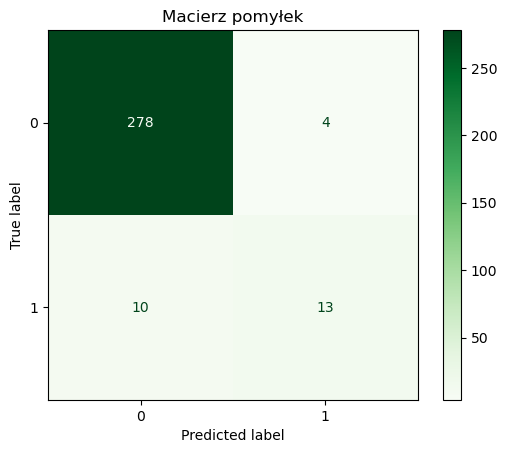

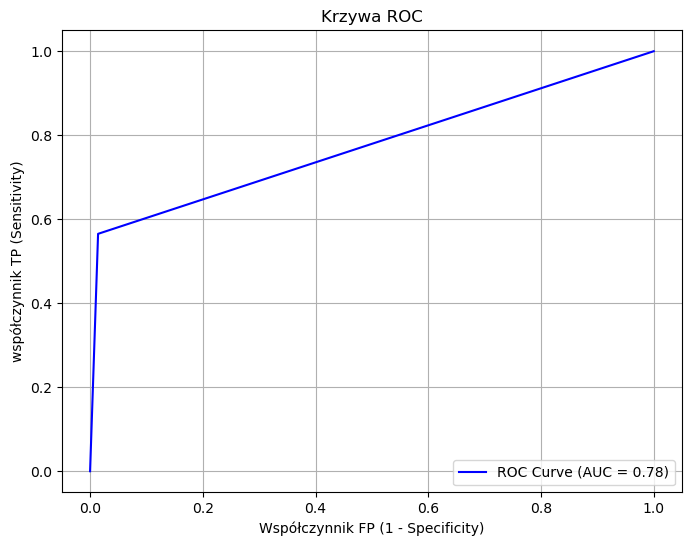

In [22]:
region_data = df_final[df_final['Location'] == best_region].drop(columns=['Location'])
y = region_data['RainTomorrow']
X = region_data.drop(columns=['RainTomorrow'])
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=259195)

print(y_train.value_counts())

start = time.time()
for _ in range(100):
    model = LogisticRegression(max_iter=1000, solver='saga')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
end = time.time()
print(f"Czas wykonania: {end - start:.5f}s.")
compute_metrics(y_test, y_pred, "Sklearn", best_region)

##### Własna:

In [23]:
def sigmoid(s, beta=1):
    return 1 / (1 + np.exp(-beta * s))

def best_region_lgr(X, y, X_test, iterations=500, eta=0.001, epsilon=1e-8):
    y = np.array(y)
    X = np.array(X, dtype=float)
    X_test = np.array(X_test, dtype=float)
    n_samples, n_features = X.shape 
    
    w = np.random.randn(n_features) * 0.01

    iters = 0
    for _ in range(iterations):
        iters += 1
        s = X @ w 
        pred = sigmoid(s)

        error = (y - pred)
        grad = eta * np.dot(X.T, error * pred * (1 - pred))
        w += grad

        if np.linalg.norm(grad) < epsilon:
            break

    s = np.dot(X_test, w)
    predictions = sigmoid(s)
    predictions = (predictions >= 0.5).astype(int)

    return predictions, w, iters


RainTomorrow
0.0    1123
1.0      93
Name: count, dtype: int64
Czas wykonania: 5.177415s dla 1000 iteracji.
Skuteczność dla własnej funkcji: 93.44%
Własna funkcja na Uluru:
Skuteczność: 93.4426%
Czułość (Recall): 47.8261%
Swoistość: 97.1631%
ROC AUC: 0.7249


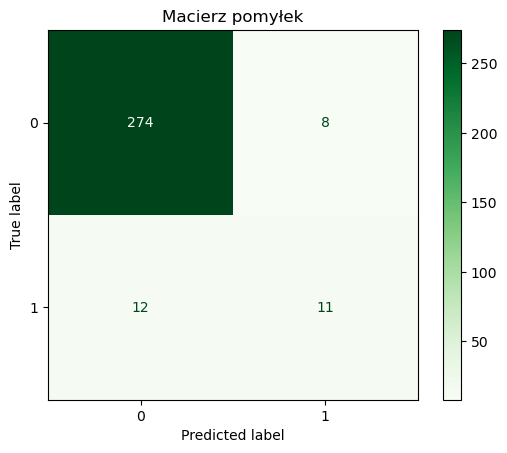

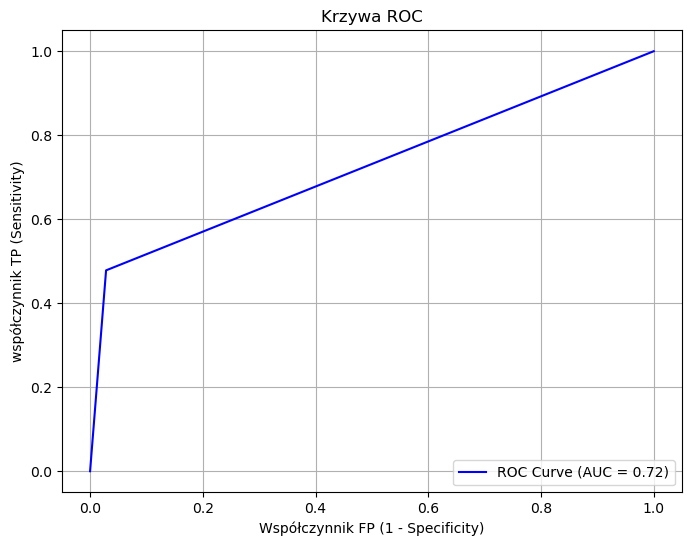

In [24]:
best_region_data = df_final[df_final['Location'] == best_region].drop(columns=['Location'])
y_best_region = best_region_data['RainTomorrow']
X_best_region = best_region_data.drop(columns=['RainTomorrow'])
    
X_train, X_test, y_train, y_test = train_test_split(X_best_region, y_best_region, test_size=0.2, stratify=y_best_region, random_state=259195)

print(y_train.value_counts())

start = time.time()
for _ in range(100):
    predictions, w, iterations = best_region_lgr(X_train, y_train, X_test, iterations=1000, eta=0.001)
end = time.time()
acc = accuracy_score(y_test, predictions)
print(f"Czas wykonania: {end - start:.6f}s dla {iterations} iteracji.")
print(f"Skuteczność dla własnej funkcji: {acc*100:.2f}%")
compute_metrics(y_test, predictions, "Własna funkcja", best_region)

#### Wyniki i obserwacje:

* Najlepszą skutecznością okazał się model dla regionu *Uluru*.
* W Australii praktycznie w ogóle nie pada, przez co wyniki są często niezrównoważone
* Ciężko przewidzieć, że będzie padać, jeśli **nie pada**

* Algorytm od *sklearn* radzi sobie odrobinę lepiej od własnej implementacji regresji logistycznej.

### 3.3 Weryfikacja skuteczności modeli regionalnych na zbiorze krajowym i porównanie skuteczności najlepszego modelu

##### Przygotowanie zbioru testowego zawierającego wszystkie zbiory testowe każdego regionu:

In [43]:
regions = df_final['Location'].unique()
df_full = df_final.drop(columns=['Location'])
y_full = df_full['RainTomorrow']
X_full = df_full.drop(columns=['RainTomorrow'])
X_full_test = pd.DataFrame()
y_full_test = pd.DataFrame()

for region in regions:
    region_data = df_final[df_final['Location'] == region].drop(columns=['Location'])
    y = region_data['RainTomorrow']
    X = region_data.drop(columns=['RainTomorrow'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=259195)
    X_full_test = pd.concat([X_full_test, X_test], ignore_index=True)
    y_full_test = pd.concat([y_full_test, y_test], ignore_index=True)

print(f"Zbiór testowy: {X_full_test.shape}, {y_full_test.shape}")

Zbiór testowy: (28457, 58), (28457, 1)


#### Testowanie pełnego zbioru krajowego dla poszczególnych regionów:

In [44]:
regions = df_final['Location'].unique()
print(regions)
results = []

for region in regions:
    region_data = df_final[df_final['Location'] == region].drop(columns=['Location'])
    y = region_data['RainTomorrow']
    X = region_data.drop(columns=['RainTomorrow'])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=259195)
    
    model = LogisticRegression(max_iter=1000, solver='saga')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_full_test) ## tutaj zmiana
    acc, sens, spec, roc_auc = calculate_metrics(y_full_test, y_pred, region=region) ## tutaj zmiana
    results.append({
        'Region': region,
        'Samples': region_data.shape[0],
        'Accuracy': acc*100,
        'Sensitivity': sens*100,
        'Specificity': spec*100,
        'ROC AUC': roc_auc*100
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False)

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
Albury: Skuteczność: 0.7627, Czułość (recall): 0.6389, Swoistość: 0.7984, ROC AUC: 0.7187
BadgerysCreek: Skuteczność: 0.8208, Czułość (recall): 0.5138, Swoistość: 0.9095, ROC AUC: 0.7117
Cobar: Skuteczność: 0.7947, Czułość (recall): 0.5757, Swoistość: 0.8580, ROC AUC: 0.7168
CoffsHarbour: Skuteczność: 0.8102, Czułość (recall): 0.5022, Swoistość: 0.8992, ROC AUC: 0.7007
Moree: Skuteczność: 0.8009, Czułość (recall): 0

In [45]:
print("10 najlepszych regionów:")
best_region = results_df.iloc[0]['Region']
results_df.head(10)

10 najlepszych regionów:


,Region,Samples,Accuracy,Sensitivity,Specificity,ROC AUC
14,Wollongong,2983,82.686158,36.645768,95.991303,66.318536
6,NorahHead,2929,82.134448,41.661442,93.830684,67.746063
1,BadgerysCreek,2928,82.081737,51.379310,90.954387,71.166849
9,Richmond,2951,82.067681,51.285266,90.963446,71.124356
30,GoldCoast,2980,82.067681,40.877743,93.971101,67.424422
20,Sale,3000,82.050111,50.141066,91.271459,70.706262
43,Hobart,3188,81.934146,42.163009,93.427549,67.795279
25,Portland,2996,81.916576,42.946708,93.178421,68.062565
42,Walpole,2819,81.811154,51.018809,90.709788,70.864299
24,Nhil,1569,81.631936,43.213166,92.734520,67.973843


#### Porównanie wyniku najlepszego regionu dla *Dummy Classifier*:

Kraj Dummy: Skuteczność: 0.7758, Czułość (recall): 0.0000, Swoistość: 1.0000, ROC AUC: 0.5000
Własna funkcja na Kraj Dummy:
Skuteczność: 77.5802%
Czułość (Recall): 0.0000%
Swoistość: 100.0000%
ROC AUC: 0.5000


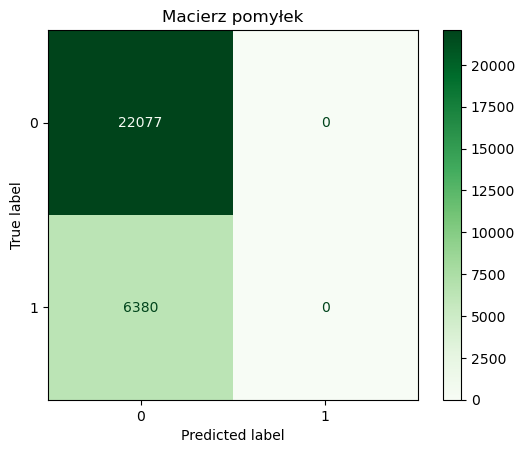

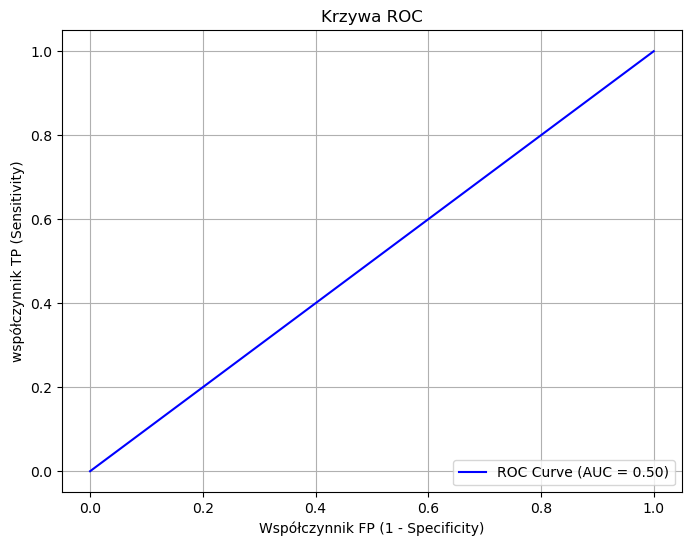

In [48]:
from sklearn.dummy import DummyClassifier
region_data = df_final[df_final['Location'] == best_region].drop(columns=['Location'])
y = region_data['RainTomorrow']
X = region_data.drop(columns=['RainTomorrow'])
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=259195)
dummy_clf = DummyClassifier(random_state=259195)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_full_test)

acc, sens, spec, roc_auc = calculate_metrics(y_full_test, y_pred, region="Kraj Dummy")
compute_metrics(y_full_test, y_pred, "Własna funkcja", "Kraj Dummy") 

#### Najlepszy model regionalny:

Sklearn na Wollongong:
Skuteczność: 82.6862%
Czułość (Recall): 36.6458%
Swoistość: 95.9913%
ROC AUC: 0.6632


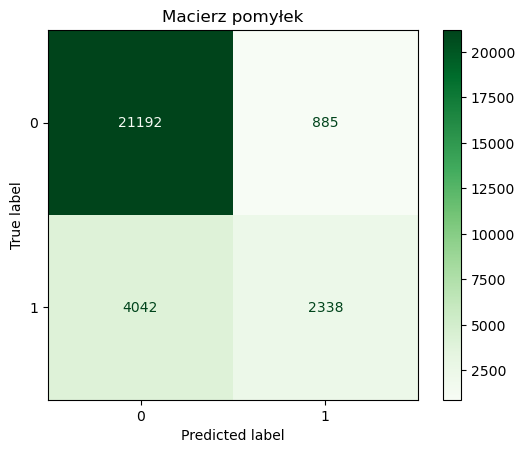

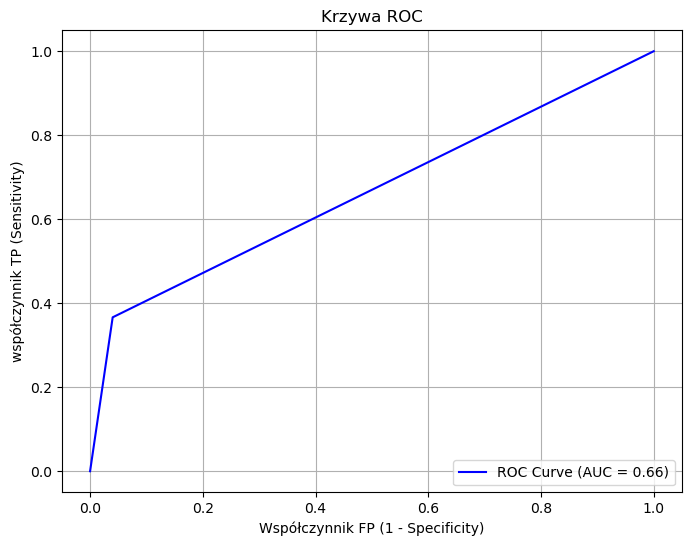

In [47]:
region_data = df_final[df_final['Location'] == best_region].drop(columns=['Location'])
y = region_data['RainTomorrow']
X = region_data.drop(columns=['RainTomorrow'])
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=259195)

model = LogisticRegression(max_iter=1000, solver='saga')
model.fit(X_train, y_train)
y_pred = model.predict(X_full_test)

compute_metrics(y_full_test, y_pred, "Sklearn", best_region)

### Wnioski i obserwacje:

* Dummy Classifier zupłenie sobie nie poradził.
* Pełen zbiór krajowy poradził sobie gorzej od dedykowanych modeli dla każdego regionu. Może na to wpływać fakt, że każdy region ma własny charakterystyczny klimat, co ułatwia modelowi dostosowanie się do swoich danych.